In [1]:
import numpy as np
import random
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

#some data generation to test my svm

np.random.seed(100)
firstCluster=np.array(0.35*np.random.randn(10 , 2) + [1.5 ,0.5])
secondCluster=np.array(0.35*np.random.randn(10 , 2) + [-1.5,0.5])
classA = np.concatenate((firstCluster,secondCluster))
classB = 0.35*np.random.randn(20 , 2) + [0.0 , -1.5]
inputs = np.concatenate( ( classA , classB ) )
targets= np.concatenate ((np.ones(classA.shape[0]) , -np.ones(classB.shape[0])))
N = inputs . shape [ 0 ] # Number of rows ( samples )
start=np.zeros(N)
permute=list ( range (N) )
random.shuffle ( permute )
inputs = inputs [ permute , : ]
targets = targets [ permute ]

In [2]:
import numpy as np
class Kernel:
    
    def __init__(self,kern_type='linear'):
        self.tag = kern_type
        self.sigma = 1
        self.p = 2
        if self.tag not in ['linear,rbf,polynomial']:
            print('Careful')
        
    def set_sigma(self,sig):
        self.sigma = sig
    
    
    def set_p(self,power):
        self.p = power 
    
    
    def value(self,x,y):
        if (self.tag=='linear'):
            return np.dot(x,y)
        elif (self.tag=='rbf'):
            return  np.exp(-(1/(2*self.sigma**2))*np.linalg.norm(x-y)**2)
        else:
            return (np.dot(x,y)+1)**self.p
        
    def rbf_kernel(self,x,y,sigma):
        return np.exp(-(1/(2*sigma**2))*np.linalg.norm(x-y)**2)

    def linear_kernel(x,y):
        return np.dot(x,y)

    def polynomial_kernel(self,x,y,p):
        return (np.dot(x,y)+1)**p



In [3]:
# A method to generate gaussian data from two classes

def generateGaussianData(seed,mean1,sigma1,mean2,sigma2,N):
    np.random.seed(seed)
    classA = np.random.multivariate_normal(mean1,sigma1,int(N/2))
    classB = np.random.multivariate_normal(mean2,sigma2,int(N/2))
    inputs = np.concatenate( ( classA , classB ) )
    targets= np.concatenate ((np.ones(classA.shape[0]) , -np.ones(classB.shape[0])))
    start=np.zeros(N)
    permute=list ( range (N) )
    random.shuffle ( permute )
    inputs = inputs [ permute , : ]
    targets = targets [ permute ]
    return targets,inputs,classA,classB
mean1=np.array([2.5,0.5])
mean2=np.array([0.0,-0.5])
sigma1=np.array([[0.35,0],[0,0.35]])
sigma2=np.array([[0.35,0],[0,0.35]])
targ, inp, clA, clB = generateGaussianData(1,mean1,sigma1,mean2,sigma2,100)

Careful
Careful


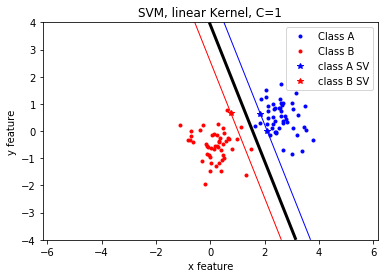

In [4]:
class SVM:
    
    def __init__(self,kernel='linear'):
        self.kernel = Kernel(kernel)
        self.a=[] #alphas of dual svm
        self.b=0 #constant b
        self.targets=[] #target variables +-1
        self.p=[] #our kernel Matrix t_i * t_j * K(x_i,x_j)
        self.inputs=[] #our inputs x_i
        self.C=0 # slack C (if we want to run SVM with slack)
        self.K=[]

    def createMatrix(self,targets,inputs): #Generate our training data matrix (that takes into account our inputs)
        N = targets.shape[0]
        result=np.zeros(shape=(N,N))
        for i in range(N):
            for j in range(N):
                result[i][j]=targets[i]*targets[j]*self.kernel.value(inputs[i],inputs[j])
        return result

    def createKernelMatrix(self,inputs): #Generate Kernel Matrix on labeled and unlabened data (useful for semi-supervised)
        N = targets.shape[0]
        result=np.zeros(shape=(N,N))
        for i in range(N):
            for j in range(N):
                result[i][j]=self.kernel.value(inputs[i],inputs[j])
        self.K = result
        return result

    def indicator(self,x): #indicator function. t[x] = 1 iff indicator(x) >=0
        number = 0
        marginIndex = np.nonzero(self.a>0.00001)
        for i in marginIndex[0]:
            number += self.a[i] * self.targets[i] * self.kernel.value(x, self.inputs[i])
        number -= self.b
        return number

    def fit_on_data(self,inputs,targets, C=0):
        N = targets.shape[0]
        self.C=C
        if (C==0): #define bounds based on whether or not we use slack

            bounds = [(0, None) for b in range(N)]
        else:
            bounds = [(0, C) for b in range(N)]

        p=self.createMatrix(targets,inputs) # get the kernel-target matrix
        self.p=p
        self.targets=targets
        self.inputs=inputs
        def objective(a): #objective function that is to be minimized
            result = np.dot(a,np.dot(self.p,a))/2 - np.sum(a)
            return result
        def zerofun(a): #constraints
            return np.dot(a,self.targets)
        #minimize the function
        initial_a=np.zeros(N)
        const = {'type': 'eq', 'fun': zerofun}
        ret = minimize(objective, initial_a,
        bounds=bounds,constraints=const)

        alpha = ret['x'] #return alphas
        self.a=alpha

        #calculating b

        marginIndex=np.nonzero(alpha>0.00001) #give me the 'meaningful' alphas
        #mI : give me the indeces corresponding to support vectors
        if C>0:
            mI=np.nonzero((alpha>0.00001) & (alpha < C))
        else:
            mI=np.nonzero((alpha>0.00001))
        marginX=inputs[mI[0]][0] #pick one SV
        targetX=targets[mI[0]][0] #and its target
        b=0
        for i in marginIndex[0]:
            b+= alpha[i]*targets[i]*self.kernel.value(marginX,inputs[i])
        b-=targetX
        self.b=b
        
    def plot_2D_SVM(self,classA,classB):
        #select the support vectors
        if self.C>0:
            marginIndex = np.nonzero((self.a>0.00001) & (self.a < self.C))
        else:
            marginIndex = np.nonzero((self.a>0.00001))
        #plot the data points per class
        plt.plot([p[0] for p in classA],
                 [p[1] for p in classA], 'b.', label='Class A')
        plt.plot([p[0] for p in classB],
                 [p[1] for p in classB],'r.',label='Class B')
        plt.plot([p[0] for p in self.inputs[marginIndex[0][self.targets[marginIndex[0]]==1]]],
                 [p[1] for p in self.inputs[marginIndex[0][self.targets[marginIndex[0]]==1]]], 'b*', label='class A SV')
        plt.plot([p[0] for p in self.inputs[marginIndex[0][self.targets[marginIndex[0]]==-1]]],
                 [p[1] for p in self.inputs[marginIndex[0][self.targets[marginIndex[0]]==-1]]], 'r*', label='class B SV')
        plt.axis('equal')
        plt.xlabel('x feature')
        plt.ylabel('y feature')
        title = 'SVM, ' + self.kernel.tag + ' Kernel, C=' + str(self.C)
        plt.title(title)

        xgrid=np.linspace(-5,5)
        ygrid=np.linspace(-4,4)

        grid = np.array([[self.indicator([x,y]) for x in xgrid] for y in ygrid]) #prepare for contour on indicator
        
        
        #contour =+1 upper border, =0 center (classification border), =-1 below border
        plt.contour(xgrid,ygrid,grid,
                   (-1.0,0.0,1.0),
                   colors=('red','black','blue'),
                   linewidths=(1,3,1))
        plt.legend()
        plt.show()
    
    def predict(self,x): #predict base on your indicator function
        N=x.shape[0]
        result = np.ones(N)
        for i in range(N):
            
            if(self.indicator(x[i])<0):
                result[i] = -1
        return result
    
    def accuracy(self,x,t): #compute the ratio (successfully classified)/total
        N = x.shape[0]
        predicted = self.predict(x)
        correct = 0
        for i in range(N):
            if predicted[i] == t[i]:
                correct+=1
        return correct/N

#creating an SVM kernel based on my class
svm = SVM(kernel='linear')
svm.fit_on_data(inp,targ,C=1)
alph = svm.a
bet = svm.b
kern = Kernel()

svm.plot_2D_SVM(clA,clB)



In [5]:
#accuracy of our svm
x=np.array(0.35*np.random.randn(1000 , 2) + [1.5 ,0.5])
t=np.ones(x.shape[0])
print('custom svm:',svm.accuracy(x,t))
from sklearn import svm as SVM

clf = SVM.SVC(kernel = 'linear', C = 1)
clf.fit(inp,targ)
print('sklearn svm:',clf.score(x,t))

custom svm: 0.654
sklearn svm: 0.654


In [57]:
import pandas as pd
# time to import the data!
df_usps_train = pd.read_csv('zip.train',delim_whitespace=True,header=None)
df_usps_test = pd.read_csv('zip.test',delim_whitespace=True,header=None)

In [58]:
#see the data a bit
print(df_usps_train.head())
print(df_usps_train.shape)

print(df_usps_test.head())
print(df_usps_test.shape)

   0    1    2    3      4      5      6      7      8      9    ...    247  \
0  6.0 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -0.631  0.862  ...  0.304   
1  5.0 -1.0 -1.0 -1.0 -0.813 -0.671 -0.809 -0.887 -0.671 -0.853  ... -0.671   
2  4.0 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  ... -1.000   
3  7.0 -1.0 -1.0 -1.0 -1.000 -1.000 -0.273  0.684  0.960  0.450  ... -0.318   
4  3.0 -1.0 -1.0 -1.0 -1.000 -1.000 -0.928 -0.204  0.751  0.466  ...  0.466   

     248    249    250    251    252    253    254    255  256  
0  0.823  1.000  0.482 -0.474 -0.991 -1.000 -1.000 -1.000 -1.0  
1 -0.671 -0.033  0.761  0.762  0.126 -0.095 -0.671 -0.828 -1.0  
2 -1.000 -1.000 -0.109  1.000 -0.179 -1.000 -1.000 -1.000 -1.0  
3  1.000  0.536 -0.987 -1.000 -1.000 -1.000 -1.000 -1.000 -1.0  
4  0.639  1.000  1.000  0.791  0.439 -0.199 -0.883 -1.000 -1.0  

[5 rows x 257 columns]
(7291, 257)
   0    1    2    3      4    5      6      7      8      9    ...    247  \
0    9 -1.0 -1.0 -1.0 

In [60]:
#train on USPS
#label data as -1 iff digit <=4, else 1
df_usps_modified = df_usps_test.copy()
for i in range(df_usps_modified.shape[0]):
    if df_usps_modified.loc[i,0] <=4:
        df_usps_modified.loc[i,0] = -1
    else:
        df_usps_modified.loc[i,0] = 1

        
print(df_usps_modified)
        

      0    1    2    3      4      5      6      7      8      9    ...  \
0       1 -1.0 -1.0 -1.0 -1.000 -1.000 -0.948 -0.561  0.148  0.384  ...   
1       1 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  ...   
2      -1 -1.0 -1.0 -1.0 -0.593  0.700  1.000  1.000  1.000  1.000  ...   
3       1 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  ...   
4       1 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -0.858 -0.106  ...   
...   ...  ...  ...  ...    ...    ...    ...    ...    ...    ...  ...   
2002   -1 -1.0 -1.0 -1.0 -1.000 -1.000 -0.417  0.814  1.000  0.775  ...   
2003    1 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -0.855  0.209  0.941  ...   
2004   -1 -1.0 -1.0 -1.0 -1.000 -0.031  0.752 -0.431 -1.000 -1.000  ...   
2005   -1 -1.0 -1.0 -1.0 -1.000 -0.534  0.578  1.000  0.301 -0.328  ...   
2006   -1 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000  0.399  0.949  ...   

        247    248    249    250    251    252  253  254  255  256  
0    -1.000 -0.908  0.430  0.6

In [61]:
seed_value=10
#sample 2000 from them
df_usps_sample = df_usps_modified.sample(2000,random_state=seed_value)

print(df_usps_sample)

      0    1      2      3      4      5      6      7      8      9    ...  \
1830   -1 -1.0 -0.123  0.647 -0.377 -0.829 -0.976 -1.000 -1.000 -1.000  ...   
36      1 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  ...   
803     1 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.324  0.909  0.790  ...   
1903    1 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.968 -0.144  0.792  ...   
1332   -1 -1.0 -1.000 -1.000 -1.000 -0.805  0.154  0.914  1.000  0.778  ...   
...   ...  ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
1032    1 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  ...   
1905   -1 -1.0 -1.000 -1.000 -1.000 -1.000  0.242  0.723 -0.521  0.135  ...   
1949   -1 -1.0 -1.000 -1.000 -0.051  0.131 -1.000 -1.000 -1.000 -1.000  ...   
1520   -1 -1.0 -1.000 -1.000 -1.000 -0.838  0.192 -0.912 -1.000 -1.000  ...   
733    -1 -1.0 -1.000 -1.000 -1.000  0.144  0.162 -1.000 -1.000 -1.000  ...   

        247    248    249    250    251    252    2

In [62]:
#method of partitioning data fram in 50*40
def partition_dataframe(df):
    result=[]
    df_to_sample_from = df.copy()
    for i in range(0,50):
        train = df_to_sample_from.sample(40,random_state=seed_value)
        remaining = df_to_sample_from.drop(train.index)
        df_to_sample_from = remaining
        result.append(train)
    return result
partition = partition_dataframe(df_usps_sample)

In [63]:
print(partition[0])
#this is just testing the first case (where we take the first 40 as train)
#Just to see accuracy
train_data = partition[0].iloc[:,1:].to_numpy()
train_targets = partition[0].iloc[:,0].to_numpy()
df_test = df_usps_sample.drop(partition[0].index)
test_data = df_test.iloc[:,1:].to_numpy()
test_targets = df_test.iloc[:,0].to_numpy()

from sklearn import svm

clf = svm.SVC(kernel='rbf',C=10,gamma='scale')
clf.fit(train_data, train_targets)
predicted = clf.predict(test_data)
N = test_targets.shape[0]
correct = 0
for j in range(N):
    if predicted[j] == test_targets[j]:
        correct+=1
print(correct/N)

'''svm = SVM(kernel='linear')
svm.fit_on_data(train_data,train_targets,C=1)
print(svm.accuracy(test_data,test_targets))'''

      0      1      2      3      4      5      6      7      8      9    ...  \
1721    1 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  ...   
1732   -1 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -0.675  0.674  0.504  ...   
1213    1 -0.848  0.043  0.662  0.662  0.662  0.662  0.662  0.662  0.279  ...   
1889    1 -1.000 -1.000 -1.000 -0.839 -0.561 -0.561 -0.561  0.082  0.998  ...   
374    -1 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -0.956  0.799  0.340  ...   
1091   -1 -1.000 -1.000 -1.000 -1.000 -1.000 -0.213  1.000  0.661 -0.264  ...   
1266    1 -1.000 -1.000 -0.995  0.163  0.890  1.000  1.000  0.820  0.524  ...   
337    -1 -1.000 -1.000 -1.000 -1.000 -1.000 -0.890 -0.664 -1.000 -1.000  ...   
935    -1 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  ...   
1614    1 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -0.621  0.602  ...   
656    -1 -1.000 -1.000 -1.000 -0.926  0.383  0.433  0.604  0.444  0.384  ...   
1994   -1 -1.000 -1.000 -1.0

"svm = SVM(kernel='linear')\nsvm.fit_on_data(train_data,train_targets,C=1)\nprint(svm.accuracy(test_data,test_targets))"

In [80]:
accuracy = np.zeros(50)
from sklearn import svm
sigma=10
gam = 1/(2*sigma**2)
#do the partition
for i in range(50):
    #for each i, use partition[i] as train, and the rest as test
    data_partition = partition[i].iloc[:,1:]
    targets = partition[i].iloc[:,0].to_numpy()
    inputs =  data_partition.to_numpy()
    test_df = df_usps_sample.drop(partition[i].index) #'drop' simply ingores the indeces from particion [i], giving us the 'rest'
    test_targets=test_df.iloc[:,0].to_numpy()
    test_inputs =test_df.iloc[:,1:].to_numpy()
    #svm = SVM(kernel='linear')
    clf = svm.SVC(kernel='rbf', C=10,gamma=gam,class_weight='balanced')
    clf.fit(inputs, targets)
    #print(test_inputs)
    #svm.fit_on_data(inputs,targets)
    #accuracy[i] = svm.accuracy(test_inputs,test_targets)
    #predicted = clf.predict(test_inputs)
    #N = test_targets.shape[0]
    #correct = 0
    #for j in range(N):
    #    if predicted[j] == test_targets[j]:
    #        correct+=1
    #accuracy[i]= correct/N
    accuracy[i] = clf.score(test_inputs,test_targets)
print('for sigma: ', s)
print(accuracy)
print('mean:', np.mean(accuracy))
print('std:', np.std(accuracy))



for sigma:  8
[0.80204082 0.77244898 0.77346939 0.75612245 0.77755102 0.8494898
 0.80153061 0.78316327 0.80969388 0.75357143 0.80816327 0.75357143
 0.78316327 0.80663265 0.76326531 0.73214286 0.76836735 0.81377551
 0.80510204 0.74183673 0.74132653 0.75612245 0.70408163 0.73010204
 0.77244898 0.78265306 0.7877551  0.76581633 0.79387755 0.7255102
 0.80816327 0.77397959 0.74642857 0.78826531 0.76530612 0.78673469
 0.74081633 0.7994898  0.76479592 0.73316327 0.75918367 0.78163265
 0.76377551 0.77040816 0.77346939 0.75357143 0.80153061 0.79285714
 0.7994898  0.79540816]
mean: 0.774265306122449
std: 0.027478960942157942
